In [2]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [43]:
df = pd.read_csv(r"C:\Users\grego\Documents\GitHub\DataVizCaptionGeneration\volume\processed\features_scaled.csv")

# we don't need this column for the analysis
df.drop("chart_fp", axis=1, inplace=True)

# remove nulls
df.dropna(inplace=True)

X = df.drop("chart_type", axis=1).drop('Unnamed: 0', axis=1)
y = df.chart_type


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
from sklearn.ensemble import RandomForestClassifier

# random forest classifier with hyperparameters tuning
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

print("Training score: ", clf.score(X_train, y_train))
print("Testing score: ", clf.score(X_test, y_test))

Training score:  0.98154972776338
Testing score:  0.8160722776985259


In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = clf.predict(X_test)

# display confusion matrix
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(1,1, figsize=(12,12))
display.plot(include_values=True, xticks_rotation='vertical', ax=ax, cmap="YlOrRd")
ax.set_xticklabels(set(y_test))
ax.set_yticklabels(set(y_test))

# save to svg
plt.savefig("confusion_matrix.svg")

plt.show()

NameError: name 'clf' is not defined

In [78]:
import pickle
pickle.dump(clf, open(r"C:\Users\grego\Documents\GitHub\DataVizCaptionGeneration\src\models\rf_clf.pkl", "wb"))


In [49]:
import matplotlib.pyplot as plt

plt.bar(X.columns, clf.feature_importances_, orientation='vertical')
plt.xticks(rotation = 90)
plt.title("Feature importances for chart type classification")
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

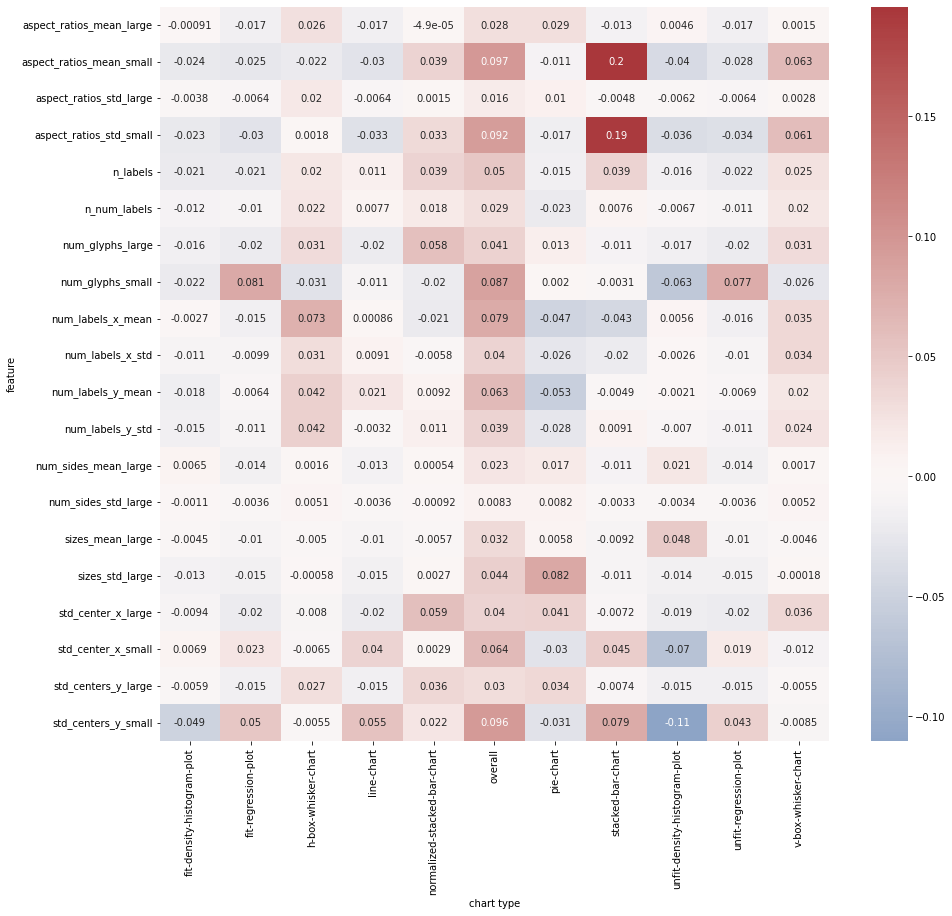

In [30]:
from sklearn.preprocessing import scale
import numpy as np
import seaborn as sns

def class_feature_importance(X, Y, feature_importances):
    # https://stackoverflow.com/questions/35249760/using-scikit-to-determine-contributions-of-each-feature-to-a-specific-class-pred
    N, M = X.shape
    X = scale(X)

    out = {}
    for c in set(Y):
        out[c] = dict(
            zip(range(N), np.mean(X[Y==c, :], axis=0)*feature_importances)
        )

    return out

# wrnagle data for visualization
data = []
for chart_type, feature_importances in class_feature_importance(X, y, clf.feature_importances_).items():
    for feature, importance in feature_importances.items():
        data.append([chart_type, X.columns[feature], importance])

# add overall importances
for feature, importance in enumerate(clf.feature_importances_):
    data.append(["overall", X.columns[feature], importance])

importances = pd.DataFrame(data, columns=["chart type", "feature", "importance"])

# plot
fig, ax = plt.subplots(1,1, figsize=(15,15))
cmap = sns.color_palette("vlag", as_cmap=True)
sns.heatmap(importances.pivot("feature", "chart type", "importance"),
            annot=True,
            center=0.00,
            ax=ax,
            cmap=cmap
            )
plt.subplots_adjust(bottom=0.2)
plt.savefig("feature_importances.svg")